## Introduction to NLP in tensorflow 

Nlp problems are also defined as seq to seq problems

In [1]:
# Get helper functions 
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves,compare_historys

2022-06-27 11:17:58.588090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 11:17:58.588123: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Dataset used is Kaggle introduction to NLP, disaster classification
#!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
    
#Data extra, por se a cobertura 
#!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

In [3]:
#unzip_data("nlp_getting_started.zip")

### Visualizing the text dataset

In [4]:
import pandas as pd

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe 
train_df_shuffled = train_df.sample(frac=1,random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
import random


In [11]:
random_index = random.randint(0,len(train_df)-5)
for row in train_df[random_index-5:random_index].itertuples():
    text,target = row[-2:]
    print(f"Target: {target}", "{real_disaster}" if target > 0 else "{not real disaster}"   )
    print(f"Text: \n \n {text}")
    print("------")

Target: 0 {not real disaster}
Text: 
 
 Free Ebay Sniping RT? http://t.co/RqIPGQslT6 Chevrolet : Avalanche Ltz Lifted 4x4 Truck ?Please Favorite &amp; Share
------
Target: 1 {real_disaster}
Text: 
 
 Chiasson Sens can't come to deal #ColoradoAvalanche #Avalanche http://t.co/2bk7laGMa9 http://t.co/bkDGCfsuiQ
------
Target: 0 {not real disaster}
Text: 
 
 Paul Rudd Emile Hirsch David Gordon Green 'Prince Avalanche' Q&amp;A | Filmmakers at Google http://t.co/e4QonKzndZ  #entretenimento #Video
------
Target: 0 {not real disaster}
Text: 
 
 Great one time deal on all Avalanche music and with purchase get a Neal Rigga shirt http://t.co/4VIRXkgMpC
------
Target: 0 {not real disaster}
Text: 
 
 .@bigperm28 was drafted by the @Avalanche in 2005 (rd. 4 #124) overall. Played last season in @UtahGrizz. http://t.co/gPGTAfMKt0
------


### Create validation set 

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_sentences,val_sentences,train_labels,val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                          train_df_shuffled["target"].to_numpy(),
                                                                          test_size=0.1,random_state=42
                                                                         )

In [14]:
len(train_sentences),len(val_sentences),len(train_labels),len(val_labels) 

(6851, 762, 6851, 762)

In [15]:
#Chech the first 10 samples 
train_sentences[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

### Convert text into numbers (let's start with tokenization )

In [16]:
import tensorflow as tf 
from tensorflow.keras.layers import TextVectorization

In [17]:
text_vectorizer = TextVectorization(max_tokens = None,#how many words
                                    standardize = "lower_and_strip_punctuation",
                                    split = "whitespace",
                                    ngrams = None,
                                    output_mode = "int",
                                    output_sequence_length = None,
                                    pad_to_max_tokens = None
                                   )

2022-06-27 11:18:04.976957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-27 11:18:04.977000: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 11:18:04.977034: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iT28200): /proc/driver/nvidia/version does not exist
2022-06-27 11:18:04.978509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
#Find the average number of tokens in the training tweets 
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [19]:
# Stup text vectorization variables 
max_vocab_length = 10000
max_length = 15 # in words 



In [20]:
text_vectorizer = TextVectorization(max_tokens = max_vocab_length,#how many words
                                    output_mode = "int",
                                    output_sequence_length = max_length,
                                   )

In [21]:
#Fit the text vectorizer to the training text 
text_vectorizer.adapt(train_sentences)

In [22]:
#Create a sample sentence and tokenize it
sample_sentence = "A cow staring at the train"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   3, 5900,    1,   17,    2,  119,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [23]:
#Choose sentence from the training set and tokenize it 
random_sentence = random.choice(train_sentences)
print(f"Original text: \n \n {random_sentence}\n\n Vectorized_version: \n\n {text_vectorizer([random_sentence]).numpy()}")

Original text: 
 
 Cyclone by Double G would be the cherry on top to this outfit! #OOTD #DoubleGhats http://t.co/JSuHuPz6Vp http://t.co/N5vrFFRbo3

 Vectorized_version: 

 [[ 582   18 1302 2981   78   21    2 5993   11  212    5   19 4975    1
     1]]


In [24]:
# Get the unique words in the vocabulary 
words_in_vocab = text_vectorizer.get_vocabulary()

In [25]:
# Top 5 words and bottom 5 words 
print(f"{words_in_vocab[:5]} are the top 5 words . \n {words_in_vocab[-5:]} are the bottom_5_words ")

['', '[UNK]', 'the', 'a', 'in'] are the top 5 words . 
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'] are the bottom_5_words 


### Create an embedding using an embedding layer 

In [26]:
from tensorflow.keras import layers 

embedding = layers.Embedding(input_dim = max_vocab_length,
                            output_dim = 128,
                            input_length = max_length)
embedding

In [27]:
#Get a random sentence from the training set 
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\n Embedded version: \n {embedding(text_vectorizer([random_sentence]))}")

Original text:
 I may have gotten a little too exited over my (home made) lava lamp. Through source http://t.co/nxTTd9NrUx http://t.co/iRQj3ZKCUz

 Embedded version: 
 [[[ 0.00414246  0.04386207  0.02549699 ...  0.04178858  0.04061863
    0.02668012]
  [-0.00554769  0.01225854 -0.04317594 ... -0.01149576  0.01513142
   -0.04350711]
  [ 0.00829574  0.01988443  0.0258964  ...  0.00654578 -0.0091311
   -0.0354569 ]
  ...
  [-0.01554769  0.03655053 -0.00053646 ... -0.02956824  0.02233976
   -0.01074396]
  [-0.03043287 -0.03696551  0.00129926 ...  0.00919835 -0.04280874
   -0.02172144]
  [ 0.00134876  0.00422161 -0.04985073 ...  0.00791746  0.01270728
    0.0166094 ]]]


In [28]:
#Check a single token embedding 
sample_embed = embedding(text_vectorizer([random_sentence]))
print(sample_embed[0][0], sample_embed[0][0].shape)
print(random_sentence)

tf.Tensor(
[ 0.00414246  0.04386207  0.02549699  0.01061247  0.03368266  0.01306986
 -0.0256884   0.03540336  0.00523617 -0.0356666   0.03919699 -0.03507842
  0.03785847 -0.01957841  0.04544142 -0.02529737  0.01131345 -0.01562642
  0.00147389  0.03522891  0.01833804 -0.02758596 -0.04944995  0.04883112
  0.01348174 -0.03349417 -0.02412988 -0.01656201 -0.00438207  0.03259074
 -0.03898363  0.04933542 -0.01638378 -0.00086443 -0.02341137 -0.0028702
  0.02487585  0.04454825 -0.03922411 -0.01076342  0.02179594 -0.04935573
  0.03556644  0.04225941  0.04844321  0.01889237  0.03445286 -0.03826291
 -0.02382511  0.03009716 -0.00536889 -0.03412162  0.03189759 -0.00894561
  0.03149301 -0.01079579  0.04134056  0.02392921 -0.01837412  0.01835365
  0.03700713  0.00725009 -0.00419511 -0.02158771  0.04367002 -0.03925779
 -0.02096289 -0.04367478 -0.02803253 -0.04721184 -0.03216223 -0.01302439
  0.01696888  0.02452937  0.01825181  0.0011449  -0.02308748 -0.03916782
  0.01718913  0.01904109 -0.01059987 -0.0

## Modelling a text dataset and running some experiments 

Model_0 : Naive-Bayes with tf-idf 

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
#Create tokenization and model pipeline 
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()), #Convert words to numbers using tfidf
    ("clf",MultinomialNB()) #model the text
])

In [30]:
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
baseline_score = model_0.score(val_sentences,val_labels)
baseline_score

0.7926509186351706

In [32]:
#Make predictions 
baseline_preds = model_0.predict(val_sentences)


### Creating an evaluation function for the experiments 

There are different metrics, so trucutrucu

In [33]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

In [34]:
def calculate_results(y_true,y_pred):
    """Calculartes model accuracy, precission 
    recall and F1-score 
    """
    #Accuracy 
    model_accuracy = accuracy_score(y_true,y_pred)*100
    #Precision, recall and F1-score weighted 
    model_precision,model_recall,model_f1,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    model_results = {"accuracy":model_accuracy,
                    "precision":model_precision,
                    "recall":model_recall,
                    "f1":model_f1}
    return model_results

In [35]:
baseline_results = calculate_results(val_labels,baseline_preds)

### Model_1 : Feed forward neural network 

In [36]:
#Firstly, create a tensorboard callback to track results 
from helper_functions import create_tensorboard_callback
#Create a directory to save tensorboard logs 
SAVE_DIR = "model_logs "

In [37]:
#Build model with the functional API 
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x)
x = layers.GlobalMaxPool1D()(x)#condense feature vector
outputs = layers.Dense(1,activation="sigmoid")(x)#Create the output layer
model_1 = tf.keras.Model(inputs,outputs,name="model_1")


In [38]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [39]:
#Compile model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [40]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                   experiment_name="model_1")])

Saving TensorBoard log files to: model_logs /model_1/20220627-111807
Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.6394 - accuracy: 0.6539 - val_loss: 0.5752 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4716 - accuracy: 0.8256 - val_loss: 0.4746 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3443 - accuracy: 0.8740 - val_loss: 0.4508 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2612 - accuracy: 0.9070 - val_loss: 0.4548 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.2008 - accuracy: 0.9314 - val_loss: 0.4686 - val_accuracy: 0.7913


In [41]:
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4686 - accuracy: 0.7913


[0.4686124324798584, 0.7913385629653931]

In [42]:
model_1_results = calculate_results(val_labels,tf.round(model_1.predict(val_sentences)).numpy())

24/24 [==============================] - 0s 2ms/step


In [43]:
import numpy as np 
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False,  True])

Tremendias 

### Visualize learned embeddings

In [44]:
# Get the vocabulary from text vectorization 
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [46]:
#Get the weight matrix of the embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()

In [47]:
print(np.array(embed_weights).shape)

(1, 10000, 128)


### Using the projector tool from tensorflow

In [48]:
#Create embedding files (from word embeddings tensorflow documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[0][index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

### Recurrent Neural networks

In [49]:
# Model_2 : LSTM
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
x = layers.LSTM(units=64,return_sequences=True)(x)
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2")


In [50]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                           

In [51]:
#Compile the model 
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [52]:
history_2 = model_2.fit(x=train_sentences,
                       y=train_labels,
                       epochs=5,
                       validation_data=(val_sentences,val_labels),
                       callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2")])

Saving TensorBoard log files to: model_logs /model_2/20220627-111831
Epoch 1/5
215/215 [==============================] - 14s 46ms/step - loss: 0.3764 - accuracy: 0.8374 - val_loss: 0.4519 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 10s 44ms/step - loss: 0.2437 - accuracy: 0.9031 - val_loss: 0.5898 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.1716 - accuracy: 0.9378 - val_loss: 0.5858 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 10s 44ms/step - loss: 0.1337 - accuracy: 0.9524 - val_loss: 0.7510 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 10s 45ms/step - loss: 0.1019 - accuracy: 0.9648 - val_loss: 0.9947 - val_accuracy: 0.7743


In [53]:
model_2_preds = tf.squeeze(tf.round(model_2.predict(val_sentences))).numpy()
model_2_results = calculate_results(val_labels,model_2_preds)

24/24 [==============================] - 1s 6ms/step


In [54]:
model_2_results

{'accuracy': 77.42782152230971,
 'precision': 0.7786304709648849,
 'recall': 0.7742782152230971,
 'f1': 0.7711035650901983}

In [55]:
# Model_3 : GRU
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.GRU(units=64,return_sequences=True)(x)
#x = layers.LSTM(units=64,return_sequences=True)(x)
#print(x.shape)
x = layers.GRU(64)(x)
#print(x.shape)
#x = layers.Dense(64,activation="relu")(x)
#x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3")


In [56]:
#Compile the model 
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [57]:
history_3 = model_3.fit(x=train_sentences,
                       y=train_labels,
                       epochs=5,
                       validation_data=(val_sentences,val_labels),
                       callbacks=[create_tensorboard_callback(SAVE_DIR,"model_3")])

Saving TensorBoard log files to: model_logs /model_3/20220627-111923
Epoch 1/5
215/215 [==============================] - 10s 34ms/step - loss: 0.2199 - accuracy: 0.9045 - val_loss: 0.7634 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 7s 32ms/step - loss: 0.1002 - accuracy: 0.9641 - val_loss: 0.8053 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0788 - accuracy: 0.9710 - val_loss: 0.8300 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0619 - accuracy: 0.9753 - val_loss: 0.8976 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0556 - accuracy: 0.9759 - val_loss: 1.0664 - val_accuracy: 0.7533


In [58]:
model_3_preds = tf.squeeze(tf.round(model_3.predict(val_sentences))).numpy()
model_3_results = calculate_results(val_labels,model_3_preds)

24/24 [==============================] - 1s 4ms/step


In [59]:
model_3_results

{'accuracy': 75.32808398950131,
 'precision': 0.753004229734441,
 'recall': 0.7532808398950132,
 'f1': 0.7530956268877401}

In [60]:
#Model_4: Bidirectional RNN
inputs = layers.Input(shape=(1,),name="inputs",dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64,))(x)
outputs = layers.Dense(1,activation =tf.keras.activations.sigmoid)(x)
model_4 = tf.keras.Model(inputs,outputs,name="model_4")

In [61]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                           

In [62]:
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])
model_4.fit(x=train_sentences,
           y=train_labels,
           epochs=5,
           validation_data=(val_sentences,val_labels),
           callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                experiment_name="model_4")])

Saving TensorBoard log files to: model_logs /model_4/20220627-112003
Epoch 1/5
215/215 [==============================] - 19s 52ms/step - loss: 0.1294 - accuracy: 0.9441 - val_loss: 0.9253 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0589 - accuracy: 0.9745 - val_loss: 1.3129 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 12s 55ms/step - loss: 0.0514 - accuracy: 0.9784 - val_loss: 1.4748 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0471 - accuracy: 0.9784 - val_loss: 1.7912 - val_accuracy: 0.7480
Epoch 5/5
215/215 [==============================] - 13s 59ms/step - loss: 0.0460 - accuracy: 0.9785 - val_loss: 1.2888 - val_accuracy: 0.7717


In [63]:
model_4_results = calculate_results(val_labels,tf.round(model_4.predict(val_sentences)))

24/24 [==============================] - 2s 9ms/step


In [64]:
model_4_results

{'accuracy': 77.16535433070865,
 'precision': 0.7751367943413853,
 'recall': 0.7716535433070866,
 'f1': 0.7687482528669142}

### Convolutional NN for text 

In [65]:
#Model_5: Conv1D
embedding_tst = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                       kernel_size=5,
                       activation="relu",
                       padding="same")
conv_1d_output = conv_1d(embedding_tst)
max_pool = layers.GlobalMaxPool1D()
max_pool_output =max_pool(conv_1d_output)

In [66]:
embedding_tst.shape,conv_1d_output.shape,max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [67]:
embedding_tst

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04627262,  0.00919561, -0.06574056, ..., -0.07419406,
         -0.05252943, -0.05278938],
        [ 0.01751778, -0.02824653, -0.05097576, ..., -0.06892952,
         -0.0286429 , -0.03931302],
        [ 0.05554759, -0.03847493, -0.03722861, ..., -0.04787545,
         -0.05433097, -0.04807238],
        ...,
        [ 0.09965701, -0.02326744, -0.04207201, ..., -0.04974445,
         -0.05307342, -0.04211177],
        [ 0.09965701, -0.02326744, -0.04207201, ..., -0.04974445,
         -0.05307342, -0.04211177],
        [ 0.09965701, -0.02326744, -0.04207201, ..., -0.04974445,
         -0.05307342, -0.04211177]]], dtype=float32)>

In [68]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters= 64,
                 kernel_size = 5,
                 activation = "relu",
                 )(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs,outputs,name="model_5")

In [69]:
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [70]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 64)                4160

In [71]:
model_5.fit(x=train_sentences,
           y=train_labels,
           epochs=5,
           validation_data=(val_sentences,val_labels),
           callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                 "model_5")])

Saving TensorBoard log files to: model_logs /model_5/20220627-112106
Epoch 1/5
215/215 [==============================] - 6s 24ms/step - loss: 0.1416 - accuracy: 0.9515 - val_loss: 0.9266 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0573 - accuracy: 0.9778 - val_loss: 1.0932 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0415 - accuracy: 0.9809 - val_loss: 1.2469 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0349 - accuracy: 0.9826 - val_loss: 1.4815 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 8s 35ms/step - loss: 0.0333 - accuracy: 0.9832 - val_loss: 1.5891 - val_accuracy: 0.7572


In [72]:
model_5_results = calculate_results(val_labels,tf.round(model_5.predict(val_sentences)))

24/24 [==============================] - 0s 3ms/step


In [73]:
model_5_results

{'accuracy': 75.7217847769029,
 'precision': 0.7599832409812126,
 'recall': 0.7572178477690289,
 'f1': 0.7542079441072491}

### Model 6 Tensorflow hub feature extractor

In [74]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                      "Omg is that the fucking akab"])
print(embed_samples[0][:50])

tf.Tensor(
[ 0.06363875  0.06158425  0.02907713  0.01009343  0.00141239 -0.04822049
  0.02682629  0.05565713  0.04665004  0.04489125  0.06711517  0.07163592
 -0.03868155  0.01240229 -0.06372787 -0.07787154  0.03454241  0.01807402
 -0.02946401 -0.00045595  0.00741567 -0.02742441  0.00801203  0.04649784
 -0.00310454  0.0518339   0.0507908   0.03404064 -0.08344434 -0.03078072
 -0.05472489 -0.06944979  0.03503908 -0.07366852 -0.05068438 -0.03965442
 -0.06214795 -0.01490314  0.01412074 -0.0173247  -0.00050386  0.06811386
 -0.05652634 -0.06010103 -0.08503088  0.06577724 -0.06609759 -0.0326493
  0.01809361 -0.01892868], shape=(50,), dtype=float32)


In [75]:
#Create a keras layer using the pretrained layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape= [],
                                       dtype = tf.string,
                                       trainable=False,
                                       name="USE")

In [76]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid",name="output_layer")
],name="model_6")

In [77]:
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [78]:
model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [79]:
model_6.fit(x=train_sentences,
           y=train_labels,
           epochs=5,
           validation_data=(val_sentences,val_labels),
           callbacks=[create_tensorboard_callback(SAVE_DIR,"model_6")])

Saving TensorBoard log files to: model_logs /model_6/20220627-112151
Epoch 1/5
215/215 [==============================] - 9s 21ms/step - loss: 0.5023 - accuracy: 0.7873 - val_loss: 0.4502 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.4142 - accuracy: 0.8152 - val_loss: 0.4368 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4009 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3935 - accuracy: 0.8246 - val_loss: 0.4284 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3874 - accuracy: 0.8266 - val_loss: 0.4256 - val_accuracy: 0.8215


In [80]:
model_6_results = calculate_results(val_labels,tf.round(model_6.predict(val_sentences)))
model_6_results

24/24 [==============================] - 1s 8ms/step


{'accuracy': 82.1522309711286,
 'precision': 0.8241317499642585,
 'recall': 0.821522309711286,
 'f1': 0.82000293386527}

### Model 7 , TF Hub , pretrained USE with 10 percent of data

In [81]:
 random.choices(range(len(train_sentences)),k=4)

[45, 941, 86, 3161]

In [82]:
split_limit = int(0.1*len(train_sentences))
rd_indexes = random.choices(range(len(train_sentences)),k=split_limit)
train_sentences_10_percent = train_sentences[rd_indexes]
train_label_10_percent = train_labels[rd_indexes]

In [83]:
np.average(train_label_10_percent)

0.4291970802919708

In [84]:
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
],name="model_7")

In [85]:
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [86]:
model_7.fit(x=train_sentences_10_percent,
           y=train_label_10_percent,
           epochs=5,
           validation_data=(val_sentences,val_labels),
           callbacks=[create_tensorboard_callback(SAVE_DIR,"model_7")])

Saving TensorBoard log files to: model_logs /model_7/20220627-112219
Epoch 1/5
22/22 [==============================] - 3s 48ms/step - loss: 0.6688 - accuracy: 0.6949 - val_loss: 0.6451 - val_accuracy: 0.7441
Epoch 2/5
22/22 [==============================] - 0s 18ms/step - loss: 0.6024 - accuracy: 0.8146 - val_loss: 0.5878 - val_accuracy: 0.7782
Epoch 3/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5285 - accuracy: 0.8117 - val_loss: 0.5345 - val_accuracy: 0.7782
Epoch 4/5
22/22 [==============================] - 1s 39ms/step - loss: 0.4635 - accuracy: 0.8131 - val_loss: 0.5003 - val_accuracy: 0.7848
Epoch 5/5
22/22 [==============================] - 1s 43ms/step - loss: 0.4189 - accuracy: 0.8263 - val_loss: 0.4849 - val_accuracy: 0.7769


In [87]:
model_7_results = calculate_results(val_labels,tf.round(model_7.predict(val_sentences)))
model_7_results

24/24 [==============================] - 1s 7ms/step


{'accuracy': 77.69028871391076,
 'precision': 0.7766466003315282,
 'recall': 0.7769028871391076,
 'f1': 0.7762334961702412}

### Comparing the performance of each of our models 

In [88]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [89]:
all_model_results = pd.DataFrame({"baseline":baseline_results,
                                "1_simple_dense":model_1_results,
                                "2_lstm":model_2_results,
                                "3_gru":model_3_results,
                                "4_bidirectional":model_4_results,
                                "5_conv1d":model_5_results,
                                "6_tf_hub_use":model_6_results,
                                "7_tf_hub_use_10_percent":model_7_results})
all_model_results = all_model_results.T

In [90]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

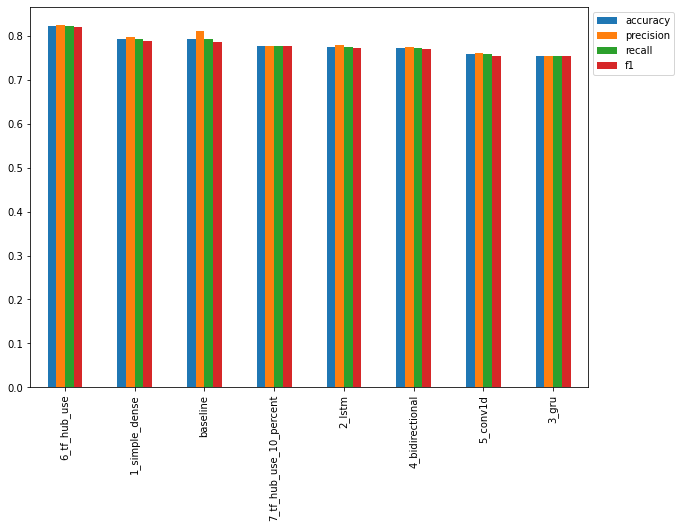

In [91]:

all_model_results.sort_values("f1",ascending=False).plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1,1))

### Uploading our model training logs to TensorBoard

In [99]:
%ls

 03-hamburger.jpeg
 03-hamburger.jpeg.1
 03-hamburger.jpeg.2
 03-pizza-dad.jpeg
 03-pizza-dad.jpeg.1
 03-pizza-dad.jpeg.2
 03-pizza-dad.jpeg.3
 03-steak.jpeg
 03-steak.jpeg.1
 03-steak.jpeg.2
 03-steak.jpeg.3
 03-steak.jpeg.4
 03-steak.jpeg.5
 03-steak.jpeg.6
 03-steak.jpeg.7
 03-sushi.jpeg
 03-sushi.jpeg.1
 03-sushi.jpeg.2
 06_101_food_class_10_percent_saved_big_dog_model/
 06_101_food_class_10_percent_saved_big_dog_model.zip
 08_model_6_USE_feature_extractor.zip
 101_classes_10_percent_data_model_checkpoint.data-00000-of-00001
 101_classes_10_percent_data_model_checkpoint.index
 101_food_classes_10_percent/
 101_food_classes_10_percent.zip
 101_food_classes_10_percent.zip.1
 10_food_classes_10_percent/
 10_food_classes_10_percent.zip
 10_food_classes_1_percent/
 10_food_classes_1_percent.zip
 10_food_classes_all_data/
 10_food_classes_all_data.zip
 10_percent_model_checkpoints/
 assets/
 best_model_HDF5_format/
 best_model_SavedModel_format/
 checkpoint
 custom_food_images/
 custom_f

In [100]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [101]:
%tensorboard --logdir ./model_logs

Reusing TensorBoard on port 6006 (pid 135396), started 0:02:18 ago. (Use '!kill 135396' to kill it.)

### Save and load the best model 

In [103]:
model_6.save("best_model.h5")
#h5 no lo guarda todo, el otro formato, sin nada, es el SavedModel

In [107]:
loaded_model_6 = tf.keras.models.load_model("best_model.h5",
                                               custom_objects ={"KerasLayer":hub.KerasLayer})

In [108]:
loaded_model_6.evaluate(val_sentences,val_labels)

24/24 [==============================] - 2s 41ms/step - loss: 0.4256 - accuracy: 0.8215


[0.42562517523765564, 0.8215222954750061]

### Finding most wrong predictions

In [110]:
# Create dataframe with all the validation wrong dl
model_pred_probs = loaded_model_6.predict(val_sentences)
model_preds = tf.squeeze(tf.round(model_pred_probs))

24/24 [==============================] - 1s 8ms/step


In [136]:
val_df = pd.DataFrame({
    "text":val_sentences,
    "target":val_labels,
    "pred":model_preds,
    "probs":model_pred_probs.reshape(-1,),
    "diff": abs(val_df["target"] - val_df["probs"])
})

In [138]:
val_df_wrong = val_df[val_df["target"]!=val_df["pred"]].sort_values("diff",ascending=False)
val_df_wrong

,text,target,pred,probs,diff
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.036125,0.963875
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038457,0.961543
38,Why are you deluged with low self-image? Take ...,1,0.0,0.045835,0.954165
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.047786,0.952214
233,I get to smoke my shit in peace,1,0.0,0.051207,0.948793
...,...,...,...,...,...
384,@nagel_ashley @Vicken52 @BasedLaRock @goonc1ty...,0,1.0,0.515176,0.515176
69,Back from Seattle Tacoma and Portland. Whirlwi...,1,0.0,0.486793,0.513207
363,@fewmoretweets all lives matter. Just not a fa...,1,0.0,0.490495,0.509505
299,@LegacyOfTheSith @SagaciousSaber @Lordofbetray...,0,1.0,0.508845,0.508845


In [142]:
rd_index = rd.randint(len())
for row in val_df_wrong[rd_index:rd_index+10].itertuples():
    _,text,target,pred,prob,_ = row
    print(f"Target: {target}, Pred: {pred}, Prob {prob} : \n\
    Text:{text}")
    print("-------------------")

Target: 1, Pred: 0.0, Prob 0.4597623348236084 : 
    Text:Tension In Bayelsa As Patience Jonathan Plans To Hijack APC PDP http://t.co/epABiNcZmJ http://t.co/1SgzGtgfw9
-------------------
Target: 1, Pred: 0.0, Prob 0.4698718190193176 : 
    Text:China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/BqBLWiw08g #ROIMentor #yycwalks
-------------------
Target: 1, Pred: 0.0, Prob 0.47205960750579834 : 
    Text:US wont upgrade its infrastructure? http://t.co/NGEHhG9YGa' it a bad situation and its going to get ugly very quickly #USA #sustainability
-------------------
Target: 0, Pred: 1.0, Prob 0.5252780318260193 : 
    Text:Emergency Response and Hazardous Chemical Management: Principles and Practices http://t.co/4sSuyhkgRB http://t.co/TDerBtgZ2k
-------------------
Target: 0, Pred: 1.0, Prob 0.5169254541397095 : 
    Text:What Natural Disaster Are You When You Get Angry? http://t.co/O9DzgZqEMf
-------------------
Target: 0, Pred: 1.0, Prob 0.5151762366294861 : 
    Text:@n

### Make predictions on the test set 

In [160]:
test_sentences = test_df["text"].to_list()

In [161]:
label_prob = loaded_model_6.predict(test_sentences)
labels = tf.round(label_prob).numpy().reshape(-1,)

102/102 [==============================] - 1s 6ms/step


In [162]:
test_df["predicted_label"] = labels
test_df["predicted_prob"] = label_prob

In [171]:
rd_index = random.randint(0,len(test_df)-5)
for row in test_df[rd_index:rd_index+5].itertuples():
    _,_,_,_,text,label,label_prob = row
    print(f"Pred: {label}, Prob {label_prob:.3f} : \n\
    Text:{text}")
    print("-------------------")

Pred: 1.0, Prob 0.724 : 
    Text:M9A1 PHROBIS III GREEN BAYONET MILITARY COMBAT SHEATH KNIFE NR http://t.co/dKxe44M8v9 http://t.co/A4PfB5Lt17
-------------------
Pred: 1.0, Prob 0.579 : 
    Text:@GorillaThumbz @FoxNews @jonathanserrie 'For sale Canadian military rifle dropped once'
-------------------
Pred: 0.0, Prob 0.129 : 
    Text:@AlexxPage cried at the mudslide cake ??
-------------------
Pred: 1.0, Prob 0.760 : 
    Text:#Tajikistan #Mudslides #China aids to #Mudslide-hit #Tajiks http://t.co/BD546mtcpN
-------------------
Pred: 0.0, Prob 0.279 : 
    Text:The one with the chocolate mudslide  #BakeOffFriends @BritishBakeOff @BBCOne #GBBO
-------------------


In [206]:
def custom_prediction(phrase,model):
    return model.predict([phrase])

In [207]:
phrase = "Hello world"
custom_prediction(phrase,loaded_model_6)

1/1 [==============================] - 0s 37ms/step


array([[0.04991131]], dtype=float32)

### Timer for predictions 

In [208]:
import time 

def pred_timer(model,samples):
    """
    Timer for hw long a model takes to make predicitons on samples     
"""
    start_time = time.perf_counter()
    model.predict(samples)
    end_time = time.perf_counter()
    total_time = end_time - start_time
    timer_per_pred = total_time/len(samples)
    return total_time,timer_per_pred

In [210]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(
model = loaded_model_6,
    samples=val_sentences
)
model_6_total_pred_time,model_6_time_per_pred

24/24 [==============================] - 0s 6ms/step


(0.21681954499217682, 0.00028454008529157064)

In [211]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(
model = model_0,
    samples=val_sentences
)
baseline_total_pred_time,baseline_time_per_pred

(0.07508889099699445, 9.854185170209246e-05)

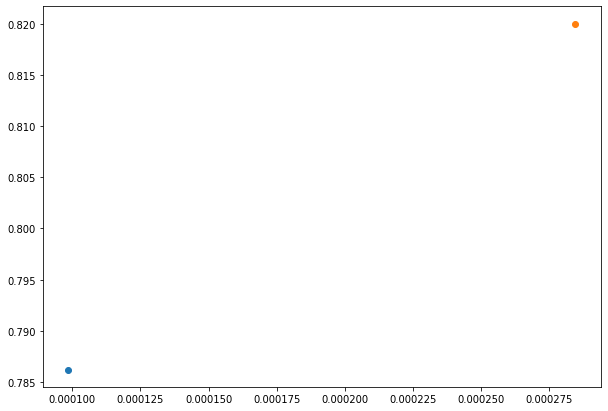

In [215]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred,baseline_results["f1"],label="baseline")
plt.scatter(model_6_time_per_pred,model_6_results["f1"],label="model_6")

### Extra curriculum 

In [217]:
model_.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [224]:
model_1_sequential = tf.keras.Sequential([
    layers.InputLayer(input_shape=(1,),dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.GlobalMaxPool1D(),
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
])
model_1_sequential.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])
model_1_sequential.fit(x=train_sentences,
                      y=train_labels,
                      epochs=5,
                      validation_data=(val_sentences,val_labels),
                      )

Epoch 1/5
215/215 [==============================] - 4s 14ms/step - loss: 0.1867 - accuracy: 0.9508 - val_loss: 0.7035 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0687 - accuracy: 0.9755 - val_loss: 0.8155 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0513 - accuracy: 0.9797 - val_loss: 0.9184 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0438 - accuracy: 0.9813 - val_loss: 0.9758 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0405 - accuracy: 0.9807 - val_loss: 1.0157 - val_accuracy: 0.7664


In [225]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                           

In [227]:
model_2_sequential = tf.keras.Sequential([
    layers.InputLayer(input_shape=(1,),dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.LSTM(64,return_sequences=True),
    layers.LSTM(64),
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
])
model_2_sequential.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])
model_2_sequential.fit(x=train_sentences,
                      y=train_labels,
                      epochs=5,
                      validation_data=(val_sentences,val_labels),
                      )

Epoch 1/5
215/215 [==============================] - 8s 26ms/step - loss: 0.1201 - accuracy: 0.9602 - val_loss: 1.0310 - val_accuracy: 0.7467
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0518 - accuracy: 0.9769 - val_loss: 1.5115 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0400 - accuracy: 0.9801 - val_loss: 1.4232 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0428 - accuracy: 0.9804 - val_loss: 1.3672 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0410 - accuracy: 0.9806 - val_loss: 1.7401 - val_accuracy: 0.7559


In [228]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 64)                4160

In [230]:
model_5_sequential = tf.keras.Sequential([
    layers.InputLayer(input_shape=(1,),dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.Conv1D(filters=64,kernel_size=4),
    layers.GlobalMaxPool1D(),
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
])
model_5_sequential.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])
model_5_sequential.fit(x=train_sentences,
                      y=train_labels,
                      epochs=5,
                      validation_data=(val_sentences,val_labels),
                      )

Epoch 1/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1130 - accuracy: 0.9596 - val_loss: 0.8879 - val_accuracy: 0.7402
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0487 - accuracy: 0.9780 - val_loss: 1.1022 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0368 - accuracy: 0.9819 - val_loss: 1.3385 - val_accuracy: 0.7520
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0318 - accuracy: 0.9829 - val_loss: 1.5304 - val_accuracy: 0.7493
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0301 - accuracy: 0.9850 - val_loss: 1.6287 - val_accuracy: 0.7480


In [237]:
model_0.fit(train_sentences_10_percent,train_label_10_percent)
model_0.score(val_sentences,val_labels)

0.7217847769028871

In [238]:
#Create a keras layer using the pretrained layer
sentence_encoder_layer_ft = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape= [],
                                       dtype = tf.string,
                                       trainable=True,
                                       name="USE")

In [242]:
model_ft = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid",name="output_layer")
],name="model_ft")

In [243]:
model_ft.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [244]:
model_ft.fit(x=train_sentences,
            y=train_labels,
            epochs=10,
            validation_data=(val_sentences,val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,"model_ft")])

Saving TensorBoard log files to: model_logs /model_ft/20220627-143619
Epoch 1/10
215/215 [==============================] - 3s 8ms/step - loss: 0.5055 - accuracy: 0.7822 - val_loss: 0.4494 - val_accuracy: 0.8005
Epoch 2/10
215/215 [==============================] - 1s 6ms/step - loss: 0.4144 - accuracy: 0.8173 - val_loss: 0.4398 - val_accuracy: 0.8045
Epoch 3/10
215/215 [==============================] - 1s 6ms/step - loss: 0.4014 - accuracy: 0.8221 - val_loss: 0.4363 - val_accuracy: 0.8136
Epoch 4/10
215/215 [==============================] - 1s 6ms/step - loss: 0.3930 - accuracy: 0.8279 - val_loss: 0.4315 - val_accuracy: 0.8123
Epoch 5/10
215/215 [==============================] - 1s 6ms/step - loss: 0.3879 - accuracy: 0.8300 - val_loss: 0.4293 - val_accuracy: 0.8150
Epoch 6/10
215/215 [==============================] - 1s 6ms/step - loss: 0.3795 - accuracy: 0.8321 - val_loss: 0.4300 - val_accuracy: 0.8123
Epoch 7/10
215/215 [==============================] - 1s 7ms/step - loss: 0.37